In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx pygraphviz matplotlib ges

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import ges

from networkx.drawing.nx_agraph import graphviz_layout
from typing import List

In [3]:
# Get machine epsilon.
e = np.finfo(np.float64).eps
print(e)

2.220446049250313e-16


# Learning Bayesian Networks from Data with Greedy Equivalent Search (GES)

## Introduction

Following the paper  "Scaling up the Greedy Equivalence Search algorithm by constraining the search space of equivalence classes" the GES algorithm was implemented.

GES is a local greedy algorithm that, unlike most Bayesian Networks algorithms which work on the space of DAGs, performs the search of the best network in the space of equivalence classes.

In order to compare two different networks an evaluation metric is required: in our case, BIC (Bayesian information criterion) was used. BIC is composed by two terms: the Log Likelihood and a penalization term. The Log Likelihood is obtained looking at the probability of every node conditioned on its parents: it is computed as the product between the absolute frequency of a node in a precise level given the configuration of its parents with the logarithm of the ratio of such quantity and the same absolute frequency not looking at the possible levels (sum on all possible levels r). The penalization term takes into account the number of possible configurations, penalizing for more complex models. In conclusion
BIC = 2*LL – penalization term

Chosen the proper metric, GES ends up the search in a local maxima w.r.t such metric. The algorithm starts with an empty DAG and is composed by two stages:

1)	FES: add dependencies to the model until it reaches a global maximum. This is performed exploiting the insert function which adds to the current CPDAG (complete PDAG which means that every directed edge in the graph are characteristic of the equivalence class), for every non adjacent nodes X and Y, an edge X -> Y. Furthermore it operates also on any subset T_0 (neighbors of Y that are not adjacent to X) by directing the previously undirected edge between T and Y as T -> Y. Once this phase ends, a local maximum is reached and the obtained graph is used as starting point for the second phase.

2)	BES: removes dependencies to the model until it reaches a global maximum following a greedy approach as well. As in the previous phase, the operations are defined through a function. Delete function, unlike insert, works on every adjacent nodes (X and Y) by deleting the edge X -> Y. Like insert function it operates on subsets as well, considering all possible between the neighbors of Y: it converts any undirected edge between H and Y into a directed one Y -> H and any does the same for X leaving only X -> H.

During both phases the BIC is evaluated in order to retrieve the best graph for every step.

Once this procedure has ended the best model is retrieved.


## Implementation

### Read Data and Graph

In [4]:
# Read data from file.
D = pd.read_csv("./final_project_data.csv", dtype = "category")
# Build the true graph.
G = nx.DiGraph([
    ("A", "T"),
    ("S", "L"),
    ("S", "B"),
    ("B", "D"),
    ("E", "D"),
    ("T", "E"),
    ("L", "E"),
    ("E", "X")
])

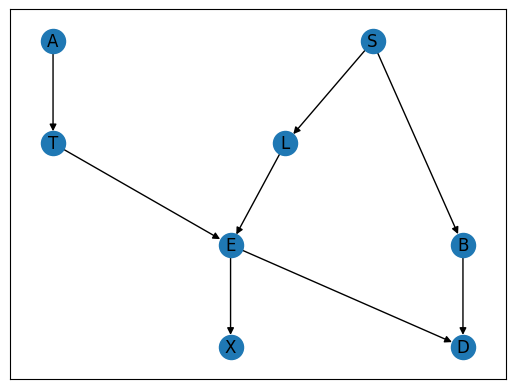

In [5]:
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

In [6]:
# Have a look to the adjacency matrix
G_matrix = nx.adjacency_matrix(G).todense()
print(G_matrix)

[[0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0]]


In [7]:
# Have a look to the provided data
display(D)

,A,S,T,L,B,E,X,D
0,no,yes,no,no,yes,no,no,yes
1,no,yes,no,no,no,no,no,no
2,no,no,yes,no,no,yes,yes,yes
3,no,no,no,no,yes,no,no,yes
4,no,no,no,no,no,no,no,yes
...,...,...,...,...,...,...,...,...
4995,no,no,no,no,yes,no,yes,yes
4996,no,no,no,no,no,no,no,no
4997,no,no,no,no,no,no,no,no
4998,no,yes,no,no,no,no,no,yes


### Computing the Absolute Frequencies

In [8]:
# Decide if you are cool or not. Remember: being cool requires time. A lot
ImCool = False

In [9]:
# Compute the absolute frequencies N(X, Pa(X) | D).
if ImCool:

  # Slow implementation of the required function without using pandas functions
  # This was my first attempt and it is cooler than the other one

  def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:
    # Create the table
    n, _ = D.shape
    q_X = 2 ** len(Z) if len(Z) != 0 else 1
    af = np.zeros((q_X, 2))

    # The idea is to create a binary string to map every possible combination
    # of "yes" and "no" to the correct entry of the matrix

    for k in range(n):
      s = ""
      row = D.iloc[k]
      if len(Z) == 0:
        s = "0"
      else:
        for p in Z:
          s += "1" if row[p] == "yes" else "0"

      # Cast the string to base 10
      s = int(s, 2)
      i = 1 if row[X] == "yes" else 0
      af[s][i] += 1
    return af

else:

  # Fast implementation of the required function using pandas functions
  # This is way less cooler than the other one, but it's fast

  def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:
    if Z == []:
      return np.array([D[X].value_counts()])
    result = pd.crosstab(D[X], [D[z] for z in Z], dropna = False)
    return np.array(result).T

In [10]:
# Compute N(A | D).
np.testing.assert_equal(
    N("A", [], D),
    np.array([[4958,   42]])
)

In [11]:
# Compute N(A, [L] | D).
np.testing.assert_equal(
    N("A", ["L"], D),
    np.array([
        [4632,   38],
        [ 326,    4]
    ])
)

In [12]:
# Compute N(A, [L, T] | D).
np.testing.assert_equal(
    N("A", ["L", "T"], D),
    np.array([
        [4594,   36],
        [  38,    2],
        [ 322,    4],
        [   4,    0]
    ])
)

### Computing the Log-Likelihood



In [13]:
# Compute the log-likelihood ll(X, Pa(X) | D).

def ll(X: str, Z: List[str], D: pd.DataFrame) -> float:
    sum = 0

    # Useful to avoid -inf log
    eps = 1e-30

    af = N(X, Z, D)

    # Possible r values are just "yes" or "no"
    r_i = 2

    # Possible combinations of parents
    q_i = 2 ** len(Z)

    for j in range(q_i):
      den = np.sum(af[j])
      if den != 0:
        for k in range(r_i):
          sum += af[j][k] * (np.log(af[j][k] / den + eps))
    return sum

In [14]:
# Compute ll(A | D).
np.testing.assert_approx_equal(
    ll("A", [], D),
    -242.5631
)

In [15]:
# Compute ll(A, [L] | D).
np.testing.assert_approx_equal(
    ll("A", ["L"], D),
    -242.3023
)

In [16]:
# Compute ll(A, [L, T] | D).
np.testing.assert_approx_equal(
    ll("A", ["L", "T"], D),
    -240.2226
)

In [17]:
# Compute the Log-Likelihood LL(G | D).
def LL(G: nx.DiGraph, D: pd.DataFrame) -> float:
    sum = 0
    for n in list(D.keys()):
      Z = list(G.predecessors(n))
      sum += ll(n, Z, D)
    return sum

In [18]:
# Compute LL(G | D).
np.testing.assert_approx_equal(
    LL(G, D),
    -11033.0871
)

### Computing the BIC

In [19]:
# Compute the Bayesian Information Criterion BIC(G | D).

def BIC(G: nx.DiGraph, D: pd.DataFrame) -> float:
    l_dataset , d = D.shape
    sum = 0
    r_i = 2
    for n in G.nodes:
      q_i = 2 ** len(list(G.predecessors(n)))
      sum += q_i * r_i

    return 2 * LL(G, D) - np.log(l_dataset) * sum

In [20]:
# BIC of the original configuration
BIC(G,D)

-22372.7932224327

### Implementing GES

In [21]:
# If it's still not clear at this point i like to implement things on my own
# Follow several useful functions

# This function generates all possible binary numbers of dim digits
# This will be useful to generate all possible subsets

def bin_numbers_Ndigits(dim: int):
  res = list()
  if dim != 0:
    for i in range(2**dim):
      n = format(i, "b")
      while len(n) != dim:
        n = '0' + n
      res.append(n)
  return res

# This functions generates all possible subsets using the elements in the
# provided list. The idea is to keep only the elements assosiated to a 1 in a
# binary string. All the string combinations are generated by the previous
# function

def subsets(T_0: list):
  res = list()
  for n in bin_numbers_Ndigits(len(T_0)):
    l = list()
    for i, c in enumerate(n):
      if c == '1': l.append(T_0[i])
    res.append(l)
  return res

# Returns all neighbors of a given node

def neighbors(X: int, M: np.ndarray) -> list:
    neigh = list()
    for i in range(len(M)):
      if i == X: continue
      if (M [X][i] & M [i][X]): neigh.append(i)
    return neigh

# Returns all adjacents of a given node

def adjacent(X: int, M: np.ndarray) -> list:
    adj = list()
    for i in range(len(M)):
      if i == X: continue
      if (M [X][i] | M [i][X]): adj.append(i)
    return adj

# Compute T0, the list of neighbors of Y which are not adjacent to X

def compute_T0(neigh_Y: list, X_adj_nodes: list) -> list:
    Ts = list()
    for i in neigh_Y:
      if i not in X_adj_nodes:
        Ts.append(i)
    return Ts

# Generate all possible subsets of T0, paying attention to the right structure
# if T0 is empty

def compute_subsets(T_0: list) -> list:
    if len(T_0) == 0:
      T_0.append([])
      subsets_list = [[]]
    else:
      subsets_list = subsets(T_0)
    return subsets_list

In [22]:
# Insert function as described in the introduction, converts directed edges
# into undirected ones, operating also on all subsets T

def insert(M: np.ndarray, X: int, Y: int, T: list) -> np.ndarray:
    # Insert X -> Y
    M[X][Y] = 1

    # Leaves only T -> Y converting the previous undirected edge into a directed
    # one
    for t in T:
      M[Y][t] = 0
    return M

# Returns the best edge to add together with the best subset

def FS(M: np.ndarray, D: pd.DataFrame) -> tuple:
    edge = None
    subset = None
    best = -np.inf
    edge_list = list(np.arange(len(M)))

    for X in edge_list:
      X_adj_nodes = adjacent(X, M)
      for Y in edge_list:
        neigh_Y = neighbors(Y, M)

        if X == Y or Y in X_adj_nodes: break
        T_0 = compute_T0(neigh_Y, X_adj_nodes)
        subsets_list = compute_subsets(T_0)

        for T in subsets_list:
          M_hyp = M.copy()
          M_hyp = insert(M_hyp, X, Y, T)
          try:
            # If the pdag can't be extended then the subset must be discarded
            G_hyp = ges.utils.pdag_to_dag(M_hyp, debug=False)
          except:
            pass
          else:
            bic_hyp = BIC(nx.from_numpy_array(G_hyp, create_using=nx.DiGraph), D)
            if bic_hyp > best:
              best = bic_hyp
              edge = (X, Y)
              subset = T
    return (edge, subset)

# Until a better graph is found keep adding edges using insert function

def FES(M: np.ndarray, D: pd.DataFrame) -> np.ndarray:
    while(True):
      edge, subset = FS(M, D)
      if edge == None: break
      M = insert(M, edge[0], edge[1], subset)

      # Transform the current pdag into a cpdag
      M = ges.utils.pdag_to_cpdag(M)
    return M

In [23]:
# Delete function as described in the introduction, converts directed edges
# into undirected ones, operating also on all subsets T

def delete(M: np.ndarray, X: int, Y: int, T: list) -> np.ndarray:
    # Deletes the edge between X and Y
    M[X][Y] = 0
    M[Y][X] = 0

    # Converts the previous undirected edges into a directed ones
    for t in T:
      M[t][Y] = 0
      M[t][X] = 0
    return M

# Returns the best edge to be removed together with the best subset

def BS(M: np.ndarray, D: pd.DataFrame) -> tuple:
    edge = None
    subset = None
    best = -np.inf

    edge_list = list(np.arange(len(M)))
    for X in edge_list:
      X_adj_nodes = adjacent(X, M)
      for Y in edge_list:
        if X == Y or Y not in X_adj_nodes: break
        neigh_Y = neighbors(Y, M)
        subsets_list = compute_subsets(neigh_Y)

        for H in subsets_list:
          M_hyp = M.copy()
          M_hyp = delete(M_hyp, X, Y, H)
          try:
            G_hyp = ges.utils.pdag_to_dag(M_hyp, debug=False)
          except:
            pass
          else:
            bic_hyp = BIC(nx.from_numpy_array(G_hyp, create_using=nx.DiGraph), D)
            if bic_hyp > best:
              best = bic_hyp
              edge = (X, Y)
              subset = H
    return (edge, subset)

# Until a better graph is found keep removing edges using delete function

def BES(M: np.ndarray, D: pd.DataFrame) -> np.ndarray:
  while(True):
      edge, subset = BS(M, D)
      if edge == None: break
      M = delete(M, edge[0], edge[1], subset)

      # Transform the current pdag into a cpdag
      M = ges.utils.pdag_to_cpdag(M)
  return M

In [24]:
# GES implementation

def GES(D: pd.DataFrame) -> np.ndarray:
    _ , d = D.shape
    # Empty graph
    eps = np.zeros((d, d), dtype=int)
    eps = FES(eps, D)
    eps = BES(eps, D)
    return eps

In [25]:
# Converts letters into numbers for simplicity
D.columns = np.arange(D.shape[1])
# Call GES on D
E_matrix = GES(D)

In [26]:
print(E_matrix)
E = nx.from_numpy_array(E_matrix, create_using=nx.DiGraph)
mapping = {0: "A", 1: "T", 2: "S", 3: "L", 4: "B", 5: "D", 6: "E", 7: "X"}

# Converts numbers into letters for simplicity
E = nx.relabel_nodes(E, mapping)

[[0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 1 0]
 [0 0 0 0 1 1 0 0]
 [0 1 0 1 1 0 0 0]]


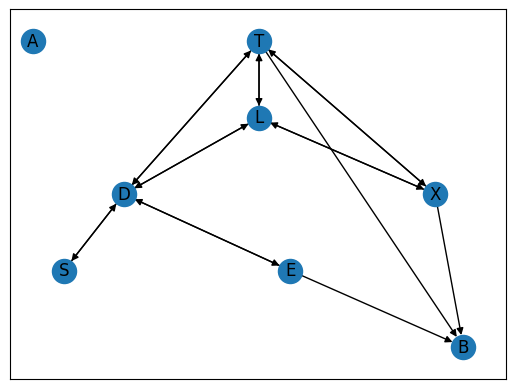

In [27]:
nx.draw_networkx(E, pos = graphviz_layout(E, prog = "dot"), with_labels = True)

### Testing GES

In [28]:
# Same edges
def same_edges(G_edges: list, E_edges: list) -> list:
  same_edges = list()
  for i in G_edges:
    if i in E_edges:
      same_edges.append(i)
  return same_edges

# Missing edges
def missing_edges(G_edges: list, E_edges: list) -> list:
  miss_edges = list()
  for i in G_edges:
    if i not in E_edges:
      miss_edges.append(i)
  return miss_edges

# Reversed edges
def reversed_edges(G_edges: list, E_edges: list) -> list:
  reversed_edges = list()
  for i in G_edges:
    for j in E_edges:
      # Check if is reversed
      if (i[0] == j[1]) & (i[1] == j[0]):
        # Check it is not undirected edge
        if i in E_edges or j in G_edges: continue
        reversed_edges.append((i[0], i[1]))
  return reversed_edges

In [29]:
G_edges = G.edges
E_edges = E.edges

print("G edges: ", G_edges)
print("E edges: ", E_edges)
print("\n")
print("There are ", len(same_edges(G_edges, E_edges)), "same edges and they are: ", same_edges(G_edges, E_edges))
print("There are ", len(missing_edges(G_edges, E_edges)), "missing edges and they are: ", missing_edges(G_edges, E_edges))
print("There are ", len(missing_edges(E_edges, G_edges)), "extra edges and they are: ", missing_edges(E_edges, G_edges))
print("There are ", len(reversed_edges(G_edges, E_edges)), "reversed edges and they are: ", reversed_edges(G_edges, E_edges))

G edges:  [('A', 'T'), ('T', 'E'), ('S', 'L'), ('S', 'B'), ('L', 'E'), ('B', 'D'), ('E', 'D'), ('E', 'X')]
E edges:  [('T', 'L'), ('T', 'B'), ('T', 'D'), ('T', 'X'), ('S', 'D'), ('L', 'T'), ('L', 'D'), ('L', 'X'), ('D', 'T'), ('D', 'S'), ('D', 'L'), ('D', 'E'), ('E', 'B'), ('E', 'D'), ('X', 'T'), ('X', 'L'), ('X', 'B')]


There are  1 same edges and they are:  [('E', 'D')]
There are  7 missing edges and they are:  [('A', 'T'), ('T', 'E'), ('S', 'L'), ('S', 'B'), ('L', 'E'), ('B', 'D'), ('E', 'X')]
There are  16 extra edges and they are:  [('T', 'L'), ('T', 'B'), ('T', 'D'), ('T', 'X'), ('S', 'D'), ('L', 'T'), ('L', 'D'), ('L', 'X'), ('D', 'T'), ('D', 'S'), ('D', 'L'), ('D', 'E'), ('E', 'B'), ('X', 'T'), ('X', 'L'), ('X', 'B')]
There are  0 reversed edges and they are:  []


# Paper algorithm

Implementation of the algorithm in the paper "Combining knowledge from different sources in causal probabilistic models". Converts a graph in a linearly ordered one for a given node

In [30]:
def order_nodes(G: nx.DiGraph) -> list:
    ordered = list()
    while(len(list(G.nodes)) != 0):
      for i in list(G.nodes):
        if(len(list(G.predecessors(i))) == 0):
          ordered.append(i)
          G.remove_node(i)
    return ordered

In [36]:
def linearly_ordered(G: nx.DiGraph, X_s: str) -> nx.DiGraph:
    ordered_list = order_nodes(G.copy())
    A = X_s
    while(len(list(G.predecessors(A))) != 0):
      for i in ordered_list[::-1]:
        if i in list(G.predecessors(A)):
          B = i
          break
      l = list(G.predecessors(A))
      l.remove(B)
      for C in l:
        if not G.has_edge(C, B):
          G.add_edge(C, B)
      A = B
    G.remove_node(X_s)
    return G

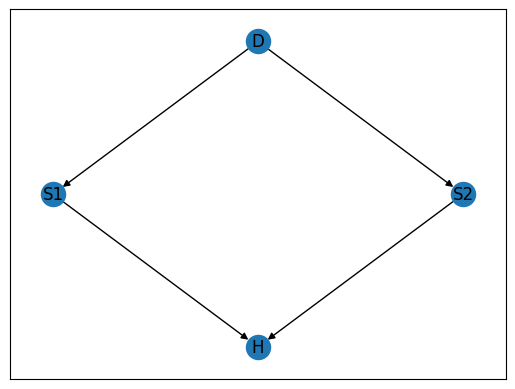

In [37]:
Gen_pop_model = nx.DiGraph([
                            ("D", "S1"),
                            ("D", "S2"),
                            ("S1", "H"),
                            ("S2", "H")
                        ])
nx.draw_networkx(Gen_pop_model, pos = graphviz_layout(Gen_pop_model, prog = "dot"), with_labels = True)

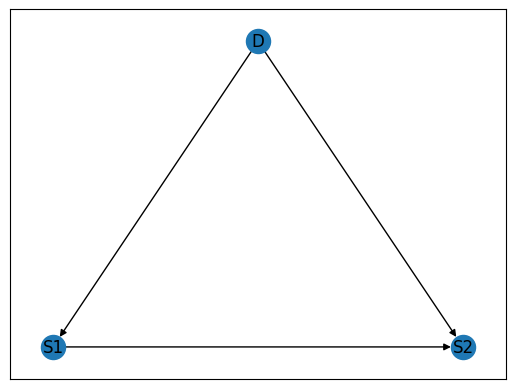

In [38]:
G_LO = linearly_ordered(Gen_pop_model.copy(), "H")
nx.draw_networkx(G_LO, pos = graphviz_layout(Gen_pop_model, prog = "dot"), with_labels = True)